<div align="center">
  <img src="logoinpe.png">
</div>


# Análise Estatística e Espectral de Processos Estocásticos (CAP-239-4)

<hr>

Docentes:
- Dr. Reinaldo Rosa
- Dr. Leonardo B. L. Santos

Discentes:
 - Fernando Cossetin;
 - Felipe Menino Carlos;
 - Felipe Perin.

<hr>

**Atividade**: Geração de casos diários sintéticos para o aumento da quantidade de pontos no conjunto de dados, feito através de uma interpolação aleatória.

**Descrição da atividade**: Desenvolva um modelo de interpolação aleatória de 23 pontos entre cada Medida diária, representando número de casos suspeitos por hora. Gere as séries e verifique se há assinatura de SOC a partir de todos os dados de flutuação. Aplique uma LTSM para prever o caso brasileiro (supervisão do Luis Arantes Filho).

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.interpolate import PchipInterpolator

import warnings
warnings.filterwarnings("ignore")

### Funções de interpolação aleatória

Para a realização deste atividade duas funções de interpolação foram criadas. A primeira, `pchip_random`, através da interpolação pchip, gera valores dentro do intervalo de duas datas. A segunda função, `interp1d_random`, através da geração de valores aleatórios dentro do intervalo dos dias utilizados faz a interpolação. 

In [2]:
def pchip_random(data: np.ndarray, datapoints = 23) -> np.ndarray:
    """Interpolação aleatória gerada com o polinômio interpolador do pchip
    
    Args:
        data (np.ndarray): Dados a serem inserpolados
        datapoints (int): Quantidade de valores geradas em um intervalo
    Returns:
        np.ndarray: Valores interpolados
    """
    interpolated_values = []
    for i in range(0, len(data) - 1):
        today = data[i]
        tomorrow = data[i + 1]
        
        if today == tomorrow:
            continue

        fnc = PchipInterpolator([0, 1], [today, tomorrow])
        elements = fnc(np.arange(0, 1, 1 / (datapoints + 1)))
        interpolated_values.extend(elements)
    return np.array(interpolated_values)

In [3]:
def interp1d_random(data: np.ndarray, datapoints = 23):
    """Interpolação aleatória gerada com elementos randômicos inteiros em um intervalo
    
    Args:
        data (np.ndarray): Dados a serem inserpolados
        datapoints (int): Quantidade de valores geradas em um intervalo
    Returns:
        np.ndarray: Valores interpolados
    """
    
    interpolated_values = []
    
    for i in range(0, len(data) - 1):
        today = data[i]
        tomorrow = data[i + 1]
        
        if today == tomorrow:
            continue # Neste caso, não há o que ser feito
        
        if today > tomorrow:
            elements = np.random.randint(tomorrow, today, datapoints).tolist()
        else:
            elements = np.random.randint(today, tomorrow, datapoints).tolist()

        elements.insert(0, today)
        elements.append(tomorrow)
        interpolated_values.extend(elements)
    return np.array(interpolated_values)

Para apresentar o comportamento de cada uma das funções implementadas, abaixo é feito a aplicação dessas nos dados e também sua visualização. Para começar, os dados são carregados.

In [4]:
data_owd = pd.read_csv('../1_conjunto_de_dados/dataset/data/blueteam_international_update_2020_06_03.csv')
data_owd['date'] = pd.to_datetime(data_owd['date'])

Abaixo, as visualizações de cada uma das interpolações criadas são feitas.

In [5]:
bra = data_owd[data_owd['iso_code'] == 'BRA'].new_cases
can = data_owd[data_owd['iso_code'] == 'CAN'].new_cases
mex = data_owd[data_owd['iso_code'] == 'MEX'].new_cases

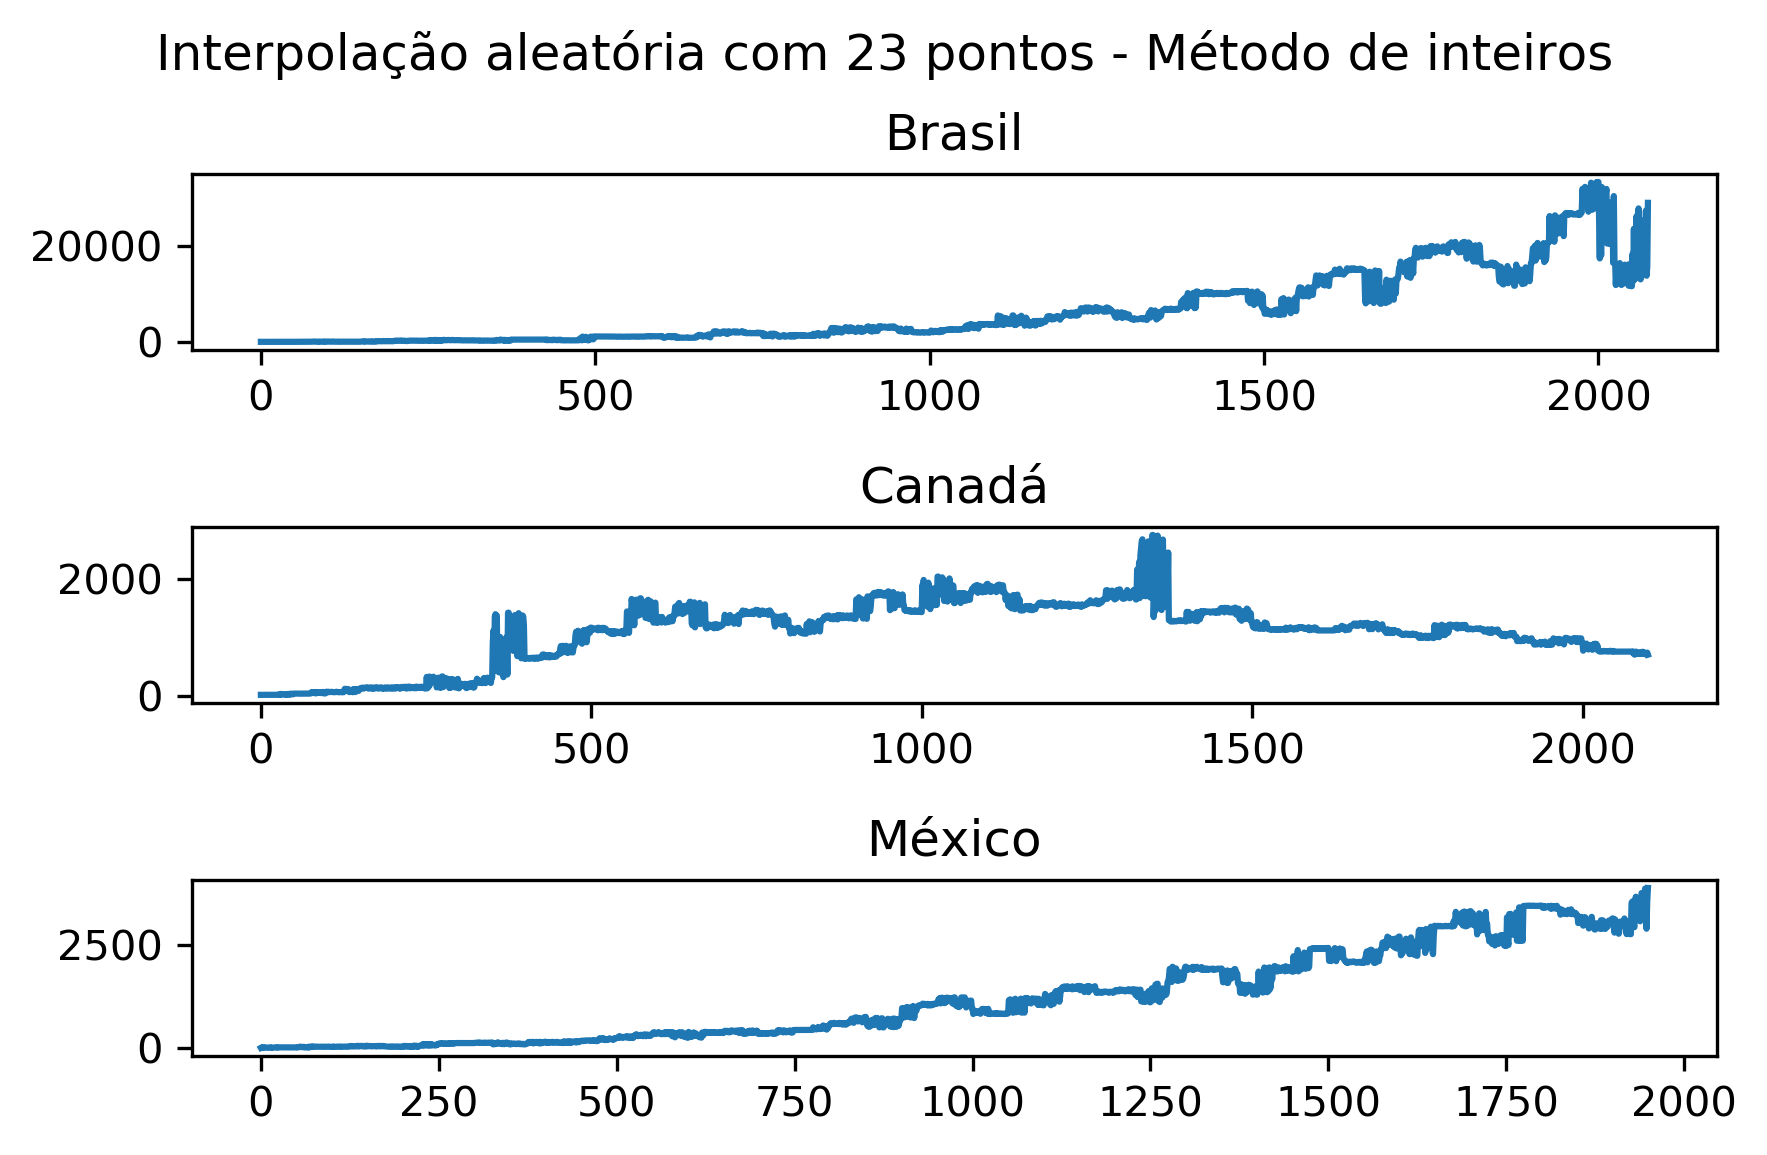

In [6]:
fig = plt.figure(dpi = 300)

plt.subplot(3, 1, 1)
plt.title("Brasil")
plt.plot(interp1d_random(bra[bra > 12].values))

plt.subplot(3, 1, 2)
plt.title("Canadá")
plt.plot(interp1d_random(can[can > 12].values))

plt.subplot(3, 1, 3)
plt.title("México")
plt.plot(interp1d_random(mex[mex > 12].values))

plt.suptitle('Interpolação aleatória com 23 pontos - Método de inteiros')
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

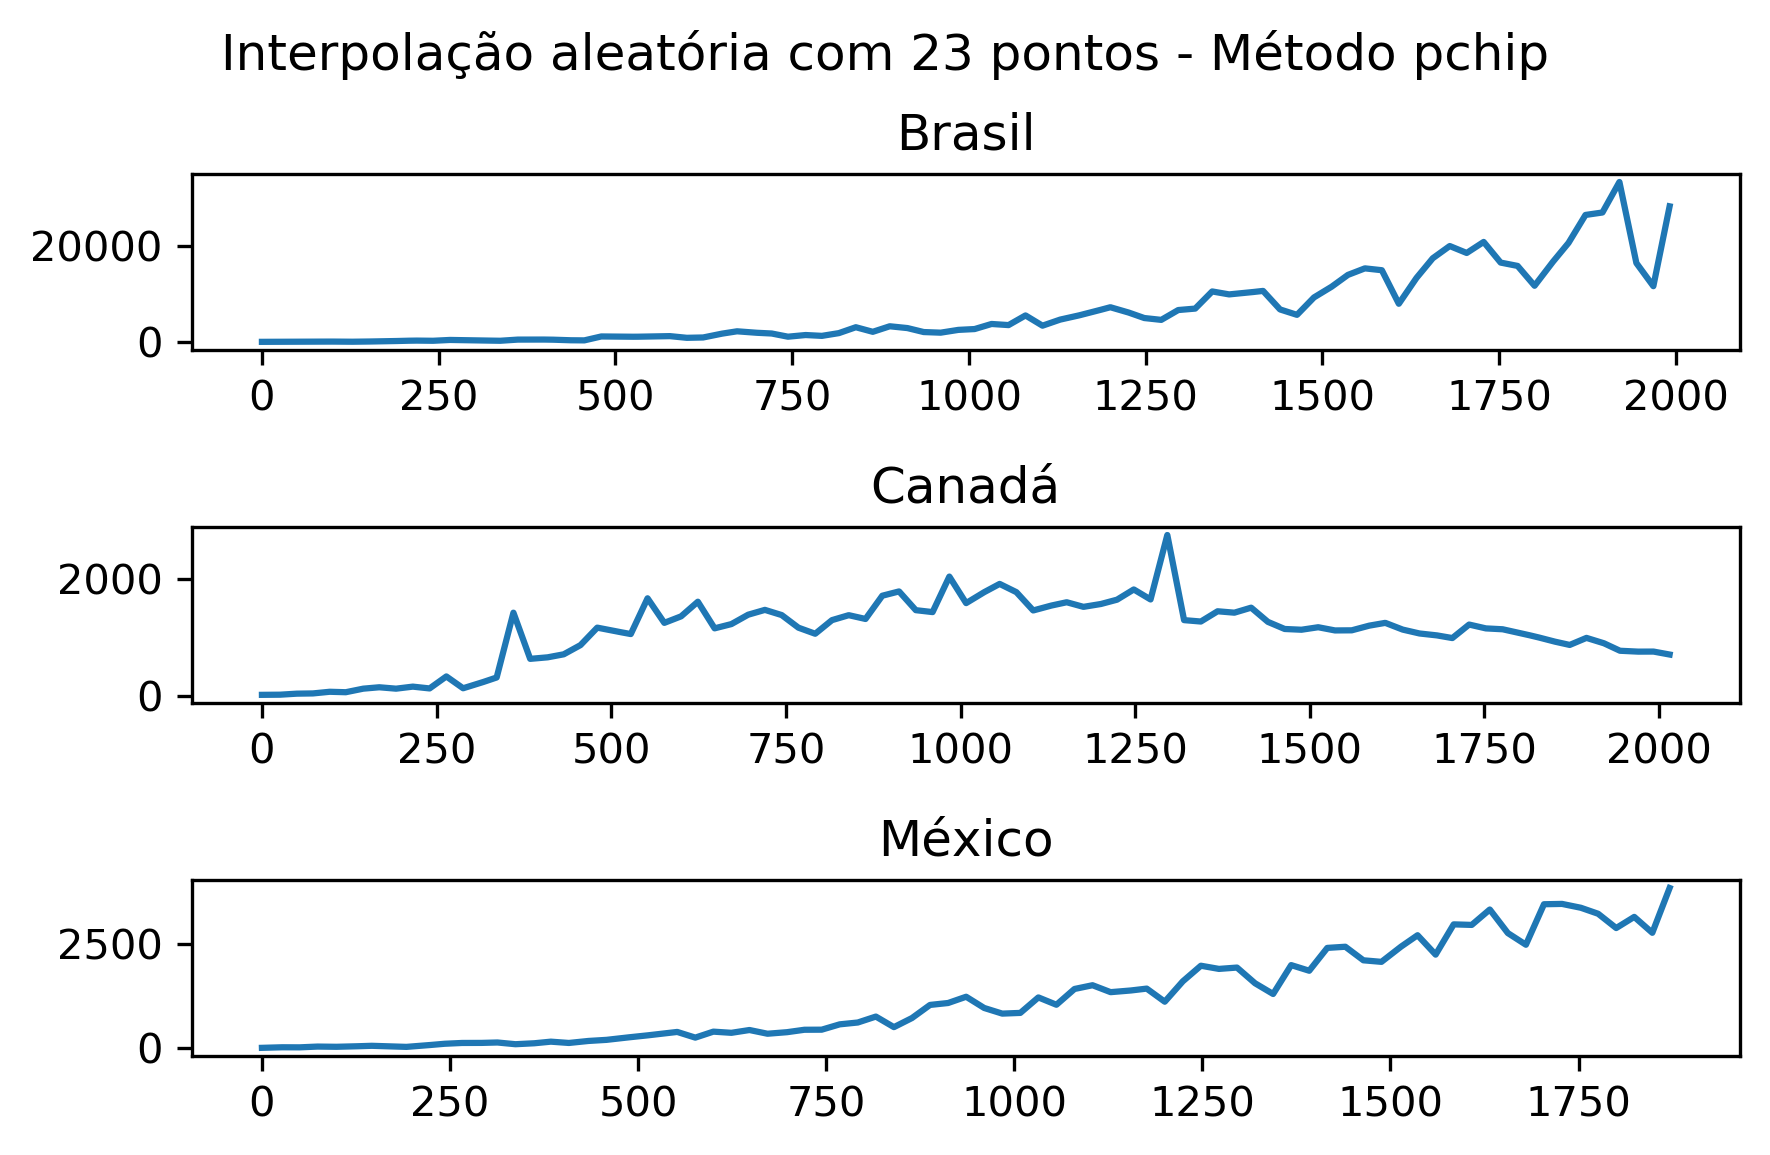

In [7]:
fig = plt.figure(dpi = 300)

plt.subplot(3, 1, 1)
plt.title("Brasil")
plt.plot(pchip_random(bra[bra > 12].values))

plt.subplot(3, 1, 2)
plt.title("Canadá")
plt.plot(pchip_random(can[can > 12].values))

plt.subplot(3, 1, 3)
plt.title("México")
plt.plot(pchip_random(mex[mex > 12].values))

plt.suptitle('Interpolação aleatória com 23 pontos - Método pchip')
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

## Self-Organized Criticality (SOC)

Abaixo, as funções de interpolação são aplicadas para a verificação da possível assinatura SOC nos dados dos países tratados neste trabalho. Também é definido a função para a visualização do SOC, esta que foi fornecida pelo professor Reinaldo Rosa.

In [8]:
def plot_soc(data, title = "SOC"):
    def SOC(data, n_bins = 50):
        n = len(data)
        mean = np.mean(data)
        var = np.var(data)
        std = np.std(data)
        """ Computa a Taxa Local de Flutuação para cada valor da ST """ 
        Gamma = []
        for i in range(0,n):
            Gamma.append((data[i] - mean)/std)
            """ Computa P[Psi_i] """
        counts, bins = np.histogram(Gamma, n_bins) 
        Prob_Gamma = []
        for i in range(0, n_bins):
            Prob_Gamma.append(counts[i] / n)
        return Prob_Gamma, counts
    
    plt.figure(dpi =  150)
    Prob_Gamma, counts = SOC(data)
    x = np.linspace(1, len(counts), len(counts))

    log_Prob = np.log10(Prob_Gamma)
    log_counts = np.log10(counts)

    p = np.array(Prob_Gamma)
    p = p[np.nonzero(p)]
    c = counts[np.nonzero(counts)]
    log_p = np.log10(p)
    log_c = np.log10(c)

    a = (log_p[np.argmax(c)] - log_p[np.argmin(c)]) / (np.max(c) - np.min(c))
    b = log_Prob[0]
    y = b * np.power(10, (a*counts))

    """ Plotagem """
    plt.clf()
    plt.scatter(np.log10(counts), y, marker=".", color="blue")

    plt.title(title, fontsize = 16) 
    plt.xlabel('log(ni)') 
    plt.ylabel('log(Yi)')
    plt.grid()
    plt.show()

Os testes abaixo serão criados apenas com a função do método inteiro

### Países

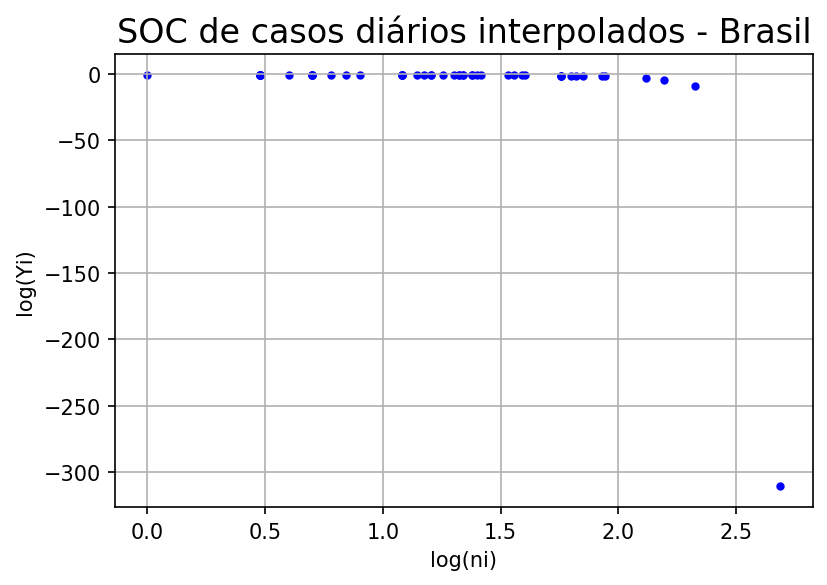

In [9]:
bra = data_owd[data_owd['iso_code'] == 'BRA'].new_cases
plot_soc(interp1d_random(bra[bra > 12].values), title = "SOC de casos diários interpolados - Brasil")

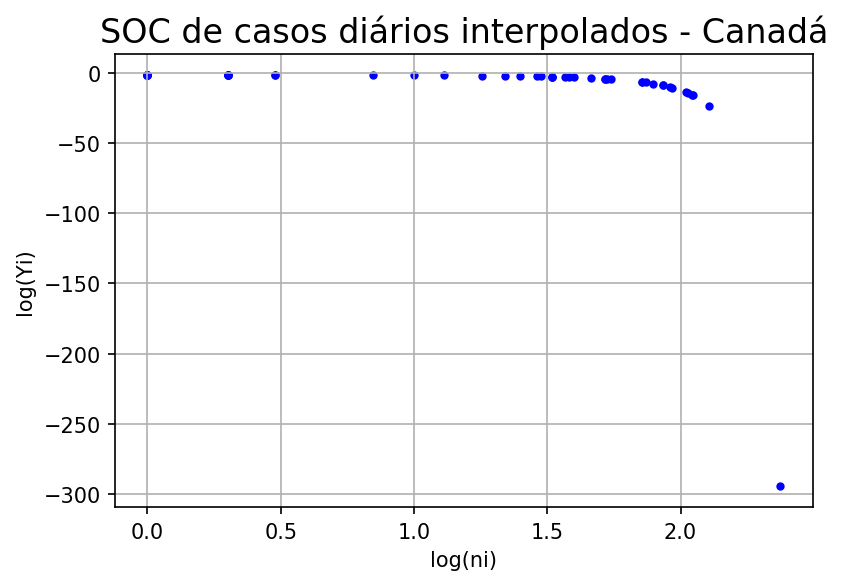

In [10]:
can = data_owd[data_owd['iso_code'] == 'CAN'].new_cases
plot_soc(interp1d_random(can[can > 12].values), title = "SOC de casos diários interpolados - Canadá")

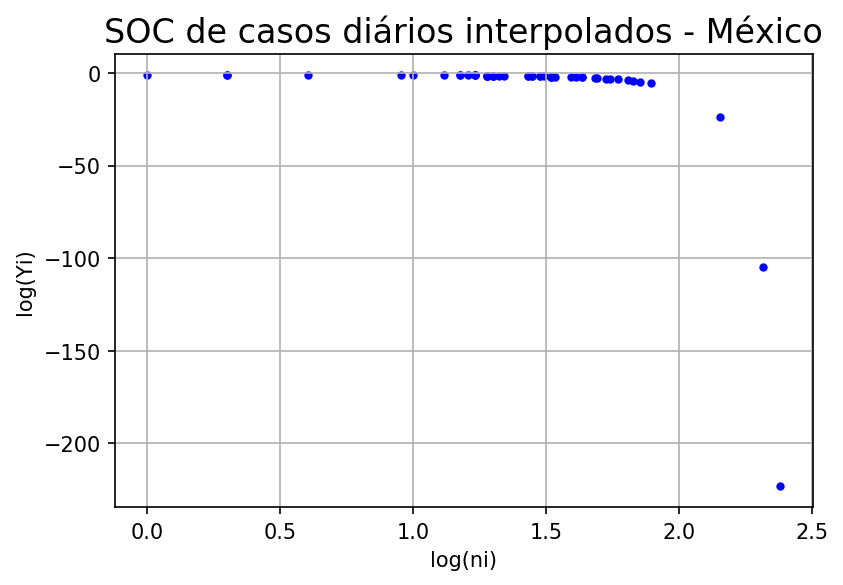

In [11]:
mex = data_owd[data_owd['iso_code'] == 'MEX'].new_cases
plot_soc(interp1d_random(mex[mex > 12].values), title = "SOC de casos diários interpolados - México")

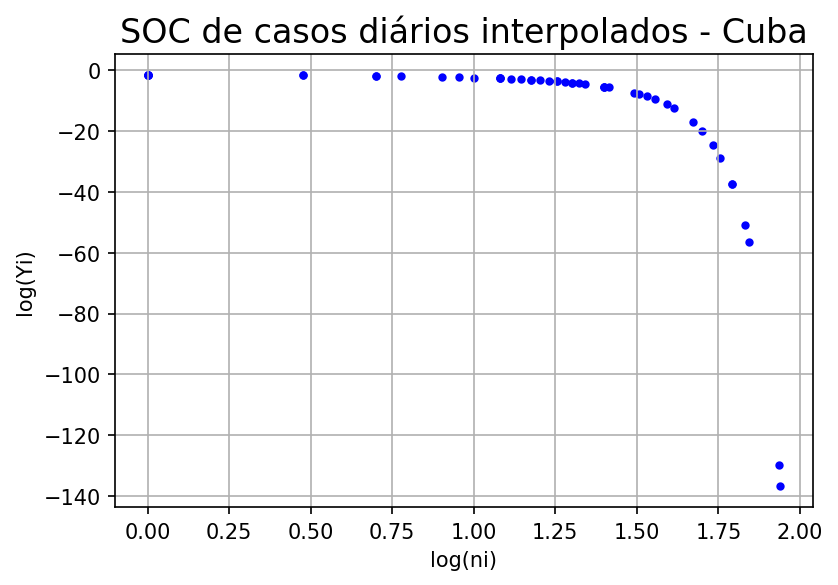

In [12]:
cub = data_owd[data_owd['iso_code'] == 'CUB'].new_cases
plot_soc(interp1d_random(cub[cub > 12].values), title = "SOC de casos diários interpolados - Cuba")

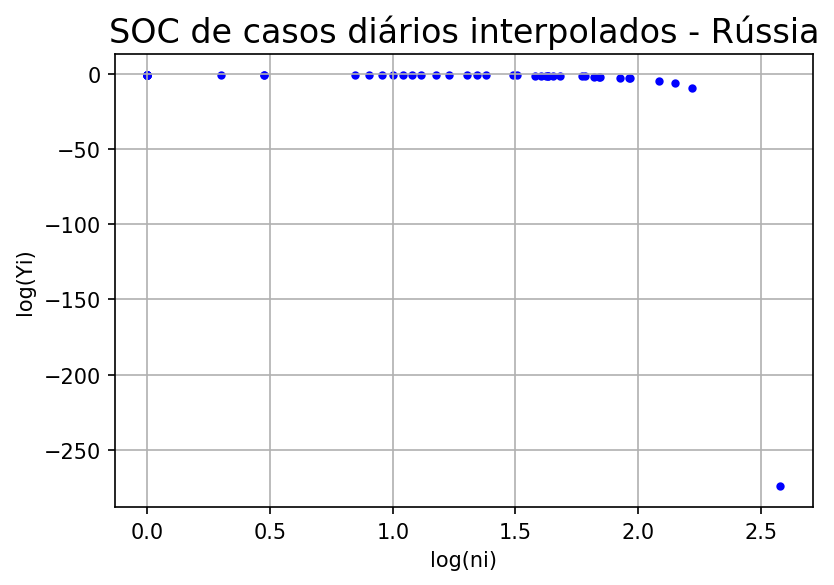

In [13]:
rus = data_owd[data_owd['iso_code'] == 'RUS'].new_cases
plot_soc(interp1d_random(rus[rus > 12].values), title = "SOC de casos diários interpolados - Rússia")

### Regionais

Abaixo, os dados de cada região tratada neste trabalho é interpolado e apresentado


In [14]:
national = pd.read_csv('../1_conjunto_de_dados/dataset/data/blueteam_national_update_2020_06_03.csv')

In [15]:
national_mg = national[national['state'] == 'MG']
national_mg = national_mg[national_mg['place_type'] == 'state']
national_mg.set_index('date', inplace = True)
national_mg = national_mg.sort_index()

Os dados originais são apresentados abaixo

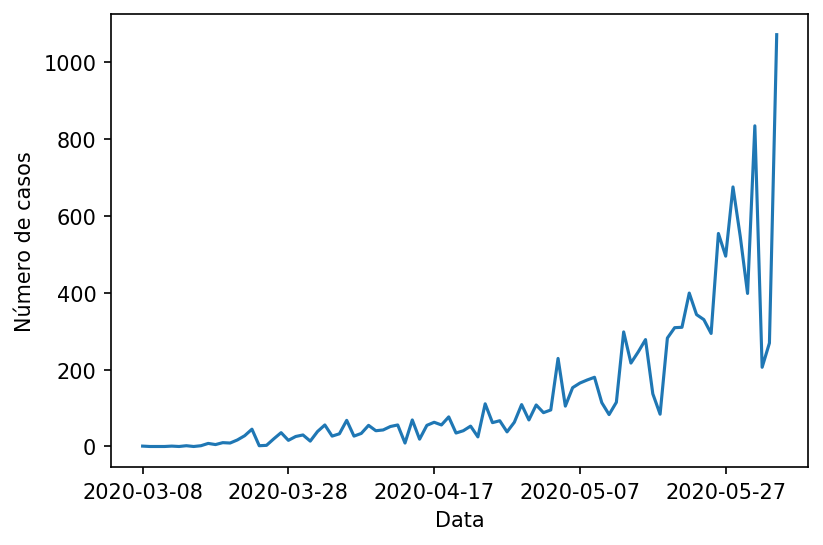

In [16]:
_, ax = plt.subplots(dpi = 150)
national_mg.new_confirmed.plot(ax = ax)
plt.xlabel("Data")
plt.ylabel("Número de casos")
plt.show()

Agora, os dados são interpolados e tem seu SOC visualizado

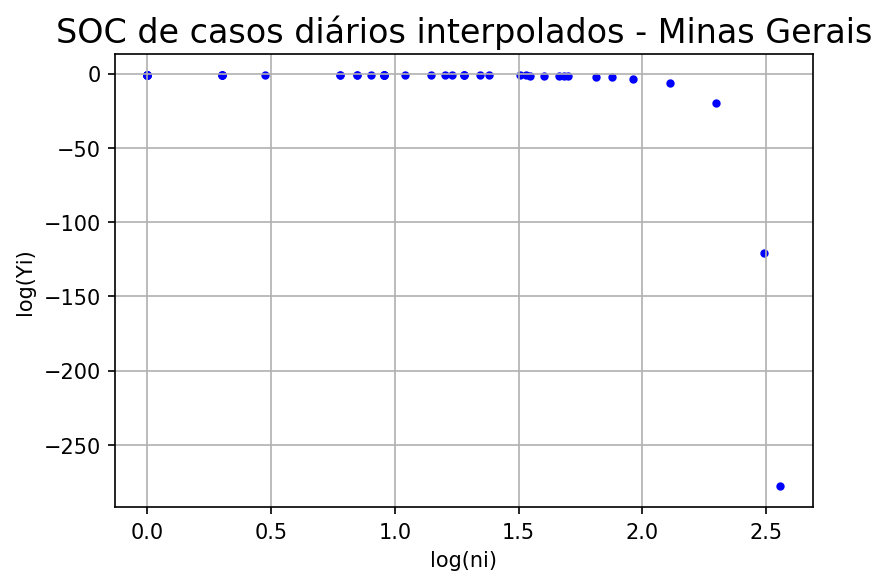

In [17]:
plot_soc(interp1d_random(national_mg[national_mg.new_confirmed > 12].new_confirmed.values), title = "SOC de casos diários interpolados - Minas Gerais")

Agora, os dados de Niterói são também apresentados

In [18]:
national_nt = national[national['state'] == 'RJ']
national_nt.set_index('date', inplace = True)
national_nt = national_nt.sort_index()
national_nt = national_nt.groupby(['date', 'state']).sum()
national_nt = national_nt[national_nt.new_confirmed > 0]

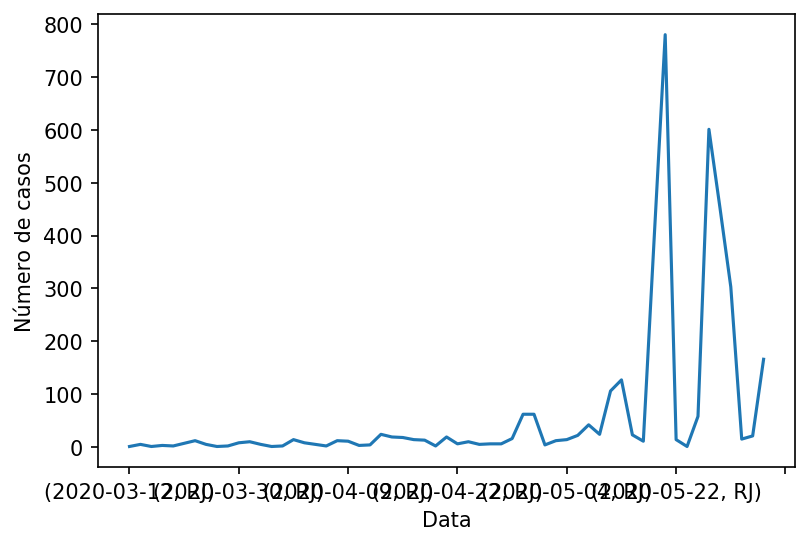

In [19]:
_, ax = plt.subplots(dpi = 150)
national_nt.new_confirmed.plot(ax = ax)
plt.xlabel("Data")
plt.ylabel("Número de casos")
plt.show()

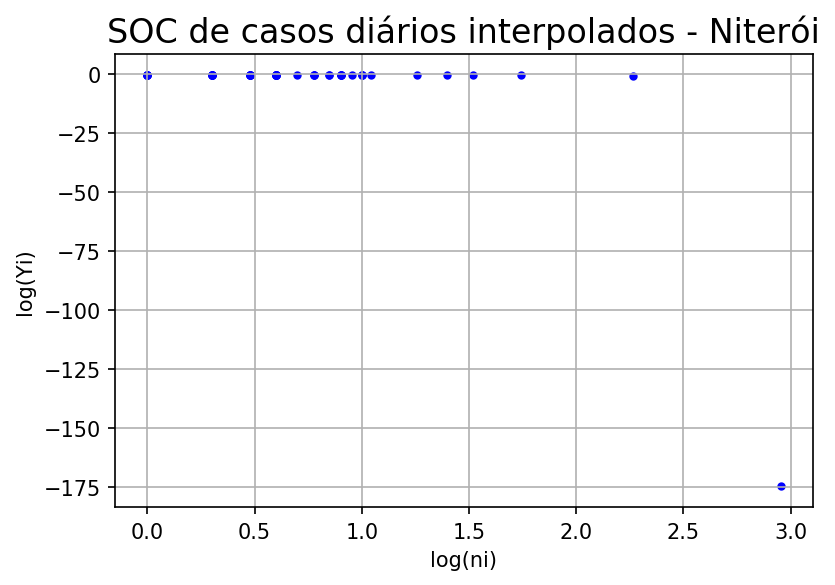

In [20]:
plot_soc(interp1d_random(national_nt.new_confirmed.values), title = "SOC de casos diários interpolados - Niterói")